# Discrete examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, time, pickle
from IPython.display import clear_output

sys.path.insert(1, '../../src/')
from discrete_mixflows import *
from gibbs import *
from concrete import *
from aux import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 32})
fig_path='fig/'
fig_path='../../../discrete-ergodic-flows-tex/fig/'

## 1D toy example

First we generate a one-dimensional synthetic example
where $\pi$ is a distribution over $\{1,\dots,10\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}\{1,\dots10\}$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show a plot of the exact density $q_N(x)$ compared to $\pi(x)$,
along with a histogram of samples from the Gibbs sampler.

In [2]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb
prbs_onedim=np.copy(prbs)

In [3]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : np.log(1/K1)*np.ones(x.shape[1])
def randq0(size): return np.random.randint(0,K1,size).reshape(1,size),np.random.rand(1,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.array(np.arange(0,K1)[np.newaxis,:],dtype=int)
u=np.random.rand(1,K1)
qvar_onedim=np.exp(lqN(x,u,N,lq0,lp,xi))

In [4]:
# compute ELBO
elbo_qN_onedim=elbo_exact(np.log(qvar_onedim/np.sum(qvar_onedim)),np.log(prbs_onedim))

In [5]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=K1)*np.ones(1)
gibbs_samples_onedim=gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.25,verbose=True)

In [6]:
# get density and compute ELBO
gibbs_density_onedim=plt.hist(gibbs_samples_onedim[0,:],density=True,bins=np.arange(0,K1+1))[0]
plt.clf()
elbo_gibbs_onedim=elbo_exact(np.log(gibbs_density_onedim),np.log(prbs_onedim))

<Figure size 1500x750 with 0 Axes>

In [7]:
########################
########################
#       Concrete       #
########################
########################
flows_onedim     = pkl_load('onedim/onedim_flows')
losses_onedim    = pkl_load('onedim/onedim_losses')
cpu_times_onedim = pkl_load('onedim/onedim_cpu_times')
sim_size_onedim  = len(flows_onedim)
max_iters_onedim = losses_onedim.shape[-1]
print('Total training time: '+str(cpu_times_onedim.sum()/3600)+' hours')

Total training time: 97.89358209561078 hours


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

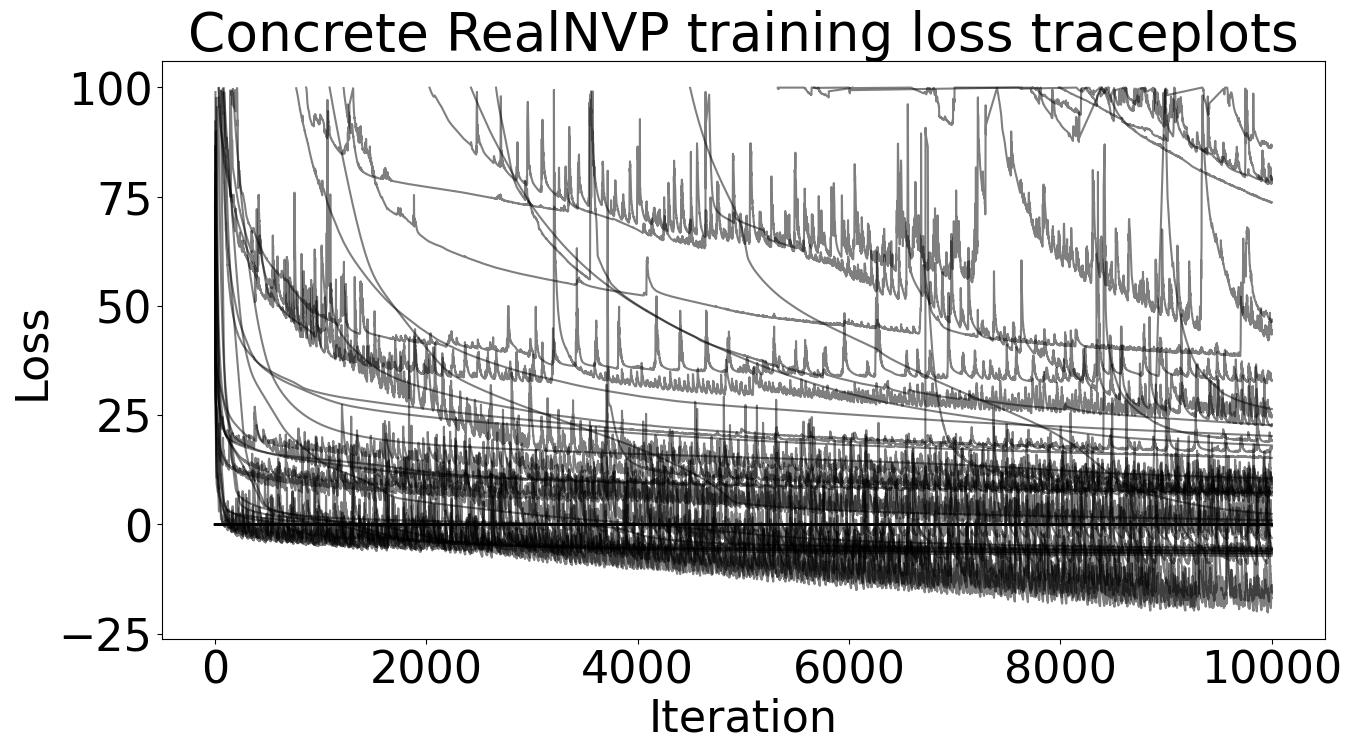

In [8]:
# loss traceplot
threshold=100
for i in range(sim_size_onedim): plt.plot(np.arange(max_iters_onedim)[losses_onedim[i,:]<threshold],losses_onedim[i,losses_onedim[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [9]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samples_onedim=np.zeros((sim_size_onedim,sample_size))
densities_onedim=np.zeros((sim_size_onedim,K1))
elbos_onedim=-np.inf*np.ones(sim_size_onedim)

for i in range(sim_size_onedim):
    print(str(i+1)+'/'+str(sim_size_onedim),end='\r')
    tmp_flow=flows_onedim[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    samples_onedim[i,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist(tmp_sample,density=True,bins=np.arange(0,K1+1))[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    densities_onedim[i,:]=tmp_density
    
    # estimate elbo
    elbos_onedim[i]=elbo_exact(np.log(tmp_density),np.log(prbs_onedim))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_26745/186026268.py:19: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_26745/186026268.py:20: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


<Figure size 1500x750 with 0 Axes>

In [10]:
i_star=np.argmax(elbos_onedim) #temp=0.5, depth=50, width=64
print('Optimal flow: '+str(i_star))

Optimal flow: 73


In [11]:
print('ELBO(qN||π)='+str(elbo_qN_onedim))
print('ELBO(qGibbs||π)='+str(elbo_gibbs_onedim))
print('ELBO(qConcrete_opt||π)='+str(elbos_onedim[np.argmax(elbos_onedim)]))

ELBO(qN||π)=-0.00040329033243014217
ELBO(qGibbs||π)=-0.0011021912472820527
ELBO(qConcrete_opt||π)=-0.0460155490187876


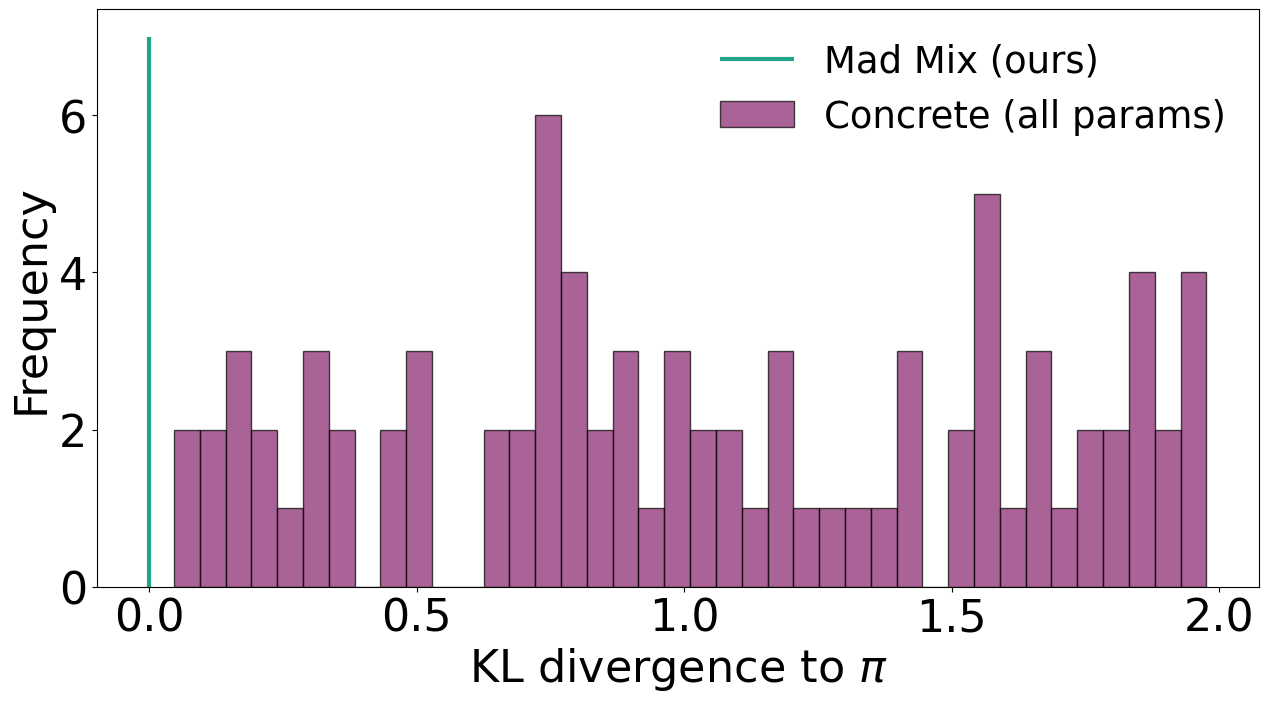

In [12]:
plt.vlines(-elbo_qN_onedim,ymin=0,ymax=7,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbos_onedim[-elbos_onedim<2],bins=40,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small',frameon=False)
plt.savefig(fig_path+'onedim_elbos.pdf', dpi=300, bbox_inches='tight')

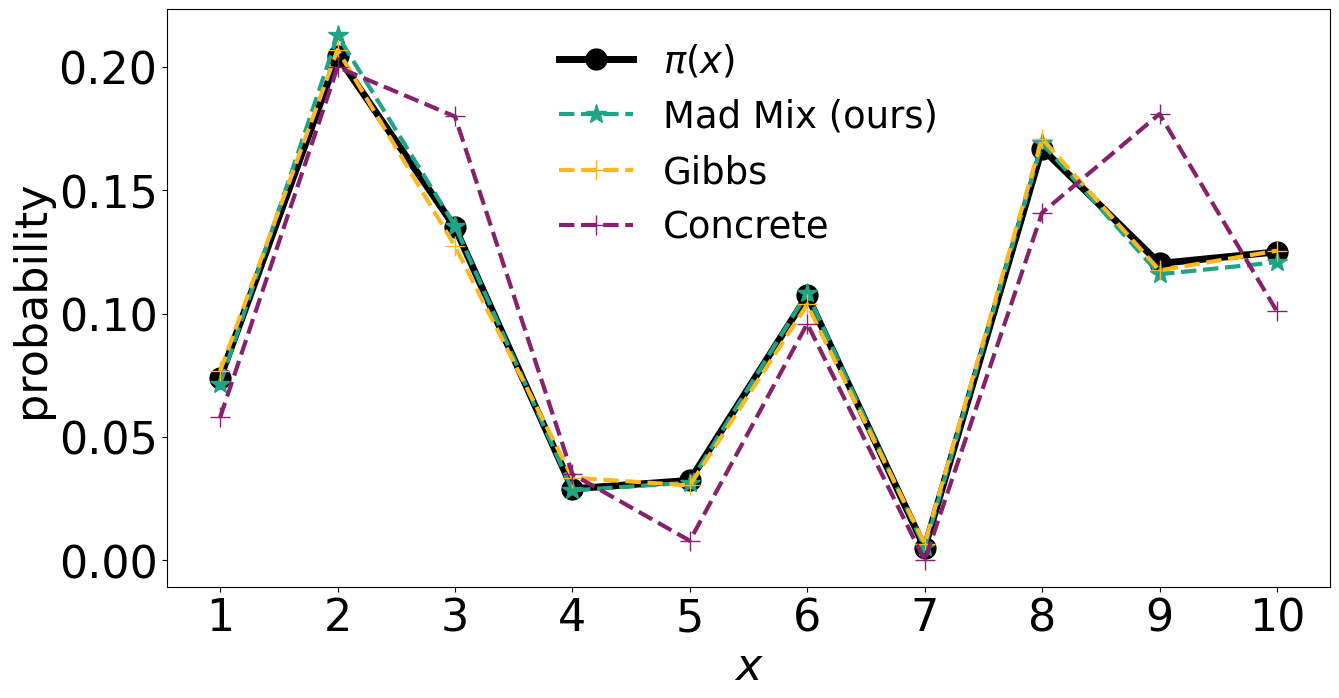

In [13]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,prbs_onedim,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,qvar_onedim/np.sum(qvar_onedim),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,gibbs_density_onedim,c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,densities_onedim[np.argmax(elbos_onedim),:],c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')
plt.savefig(fig_path+'onedim_prbs.pdf', dpi=300, bbox_inches='tight')

## 2D toy example

Now we generate a two-dimensional synthetic example
where $\pi$ is a distribution over 
$\mathcal{X}=\{1,\dots,4\}\times\{1,\dots,5\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}(\mathcal{X})$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show plots of the exact marginal densities $q_N(x_m)$ compared to $\pi(x_m)$,
$m=1,2$, along with a corresponding histogram of samples from the Gibbs sampler.

In [14]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    ext_lprb=np.log(np.moveaxis(np.repeat(prbs[:,:,np.newaxis],x.shape[1],axis=-1),2,0)) # stack d copies of logp vertically
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x[0,:],x[1,:]]) # for each d, return lp(x)
    if axis==0: return ext_lprb[np.arange(0,x.shape[1]),:,x[1,:]]
    if axis==1: return ext_lprb[np.arange(0,x.shape[1]),x[0,:],:]
    raise Exception("Axis out of bounds - there aren't that many variables")
prbs_twodim=np.copy(prbs)

In [15]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : -np.log(K1*K2)*np.ones(x.shape[1])
def randq0(size): return np.vstack((np.random.randint(0,K1,size),np.random.randint(0,K2,size))).T,np.random.rand(size,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
# first create a grid of values of x1 and x2
# adapted from https://stackoverflow.com/questions/27286537/numpy-efficient-way-to-generate-combinations-from-given-ranges
x = np.mgrid[0:K1,0:K2] 
x = np.rollaxis(x, 0, 3)
x = x.reshape((K1*K2,2)).T
myx=np.copy(x)
# now sample u and evaluate density
u=np.random.rand(2,K1*K2)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))
qvar_twodim=qvar.reshape(prbs.shape) # to move back from (K1*K2,) to (K1,K2) array

In [16]:
elbo_qN_twodim=elbo_exact(np.log(qvar_twodim/np.sum(qvar_twodim)),np.log(prbs_twodim))

In [17]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
gibbs_ss=5000
x0=np.array([np.random.randint(low=0,high=K1),np.random.randint(low=0,high=K2)])
gibbs_samples_twodim=gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.25,verbose=True)

In [18]:
# get density and compute ELBO
gibbs_density_twodim=plt.hist2d(gibbs_samples_twodim[0,:],gibbs_samples_twodim[1,:],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)])[0]
plt.clf()
elbo_gibbs_twodim=elbo_exact(np.log(gibbs_density_twodim),np.log(prbs))

<Figure size 1500x750 with 0 Axes>

In [19]:
########################
########################
#       Concrete       #
########################
########################
flows_twodim     = pkl_load('twodim/twodim_flows')
losses_twodim    = pkl_load('twodim/twodim_losses')
cpu_times_twodim = pkl_load('twodim/twodim_cpu_times')
sim_size_twodim    = len(flows_twodim)
max_iters_twodim   = losses_twodim.shape[-1]
print('Total training time: '+str(cpu_times_twodim.sum()/3600)+' hours')

Total training time: 122.75945119639968 hours


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

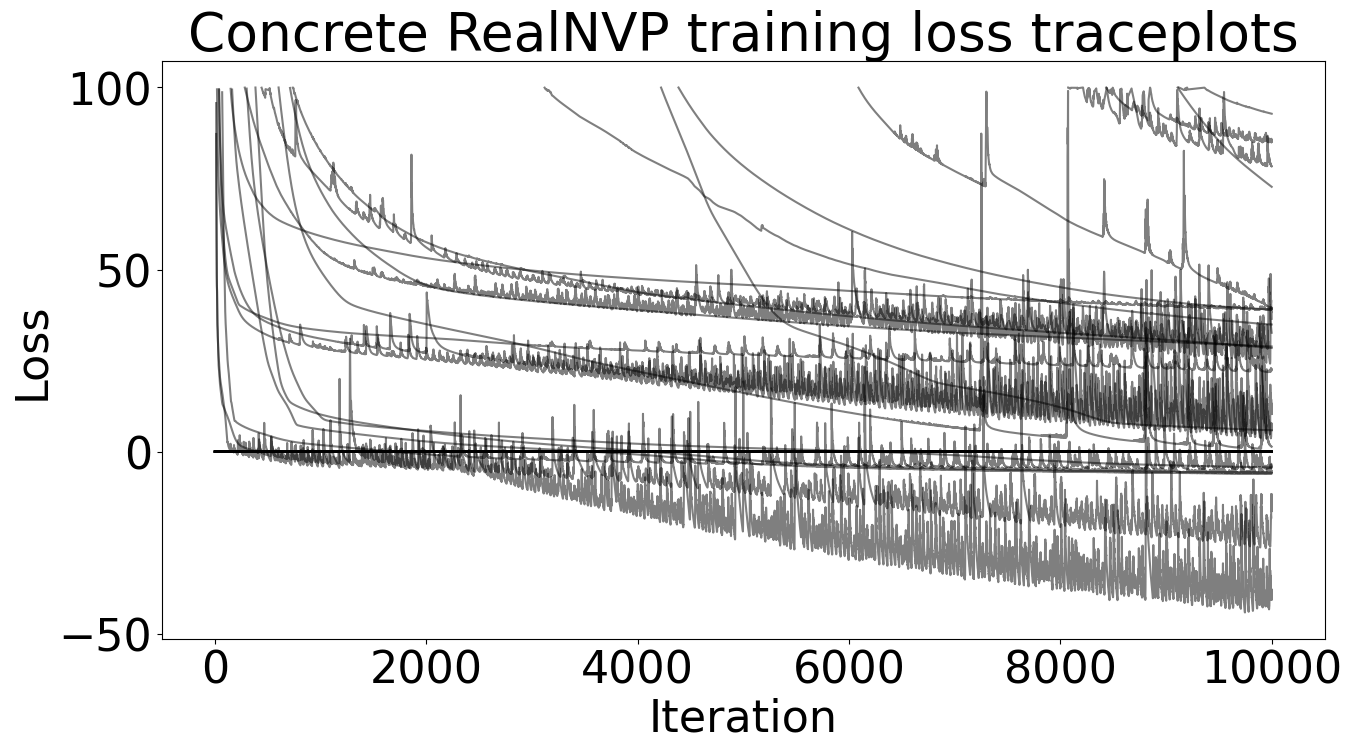

In [20]:
# loss traceplot
threshold=100
for i in range(sim_size_twodim): plt.plot(np.arange(max_iters_twodim)[losses_twodim[i,:]<threshold],losses_twodim[i,losses_twodim[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [21]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samples_twodim=np.zeros((sim_size_twodim,2,sample_size))
densities_twodim=np.zeros((sim_size_twodim,K1,K2))
elbos_twodim=-np.inf*np.ones(sim_size_twodim)

for i in range(sim_size_twodim):
    print(str(i+1)+'/'+str(sim_size_twodim),end='\r')
    tmp_flow=flows_twodim[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflatten(tmp_sample,K2) # 1d->2d
    samples_twodim[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist2d(tmp_sample[0,:],tmp_sample[1,:],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)])[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    densities_twodim[i,:]=tmp_density
    
    # estimate elbo
    elbos_twodim[i]=elbo_exact(np.log(tmp_density),np.log(prbs))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_26745/1569424033.py:19: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_26745/1569424033.py:20: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<Figure size 1500x750 with 0 Axes>

In [22]:
i_star_twodim=np.argmax(elbos_twodim)
print('Optimal flow: '+str(i_star_twodim))

Optimal flow: 80


In [23]:
print('ELBO(qN||π)='+str(elbo_qN_twodim))
print('ELBO(qGibbs||π)='+str(elbo_gibbs_twodim))
print('ELBO(qConcrete_opt||π)='+str(elbos_twodim[np.argmax(elbos_twodim)]))

ELBO(qN||π)=-0.002000021625141389
ELBO(qGibbs||π)=-0.001618205026667569
ELBO(qConcrete_opt||π)=-0.1019673504082691


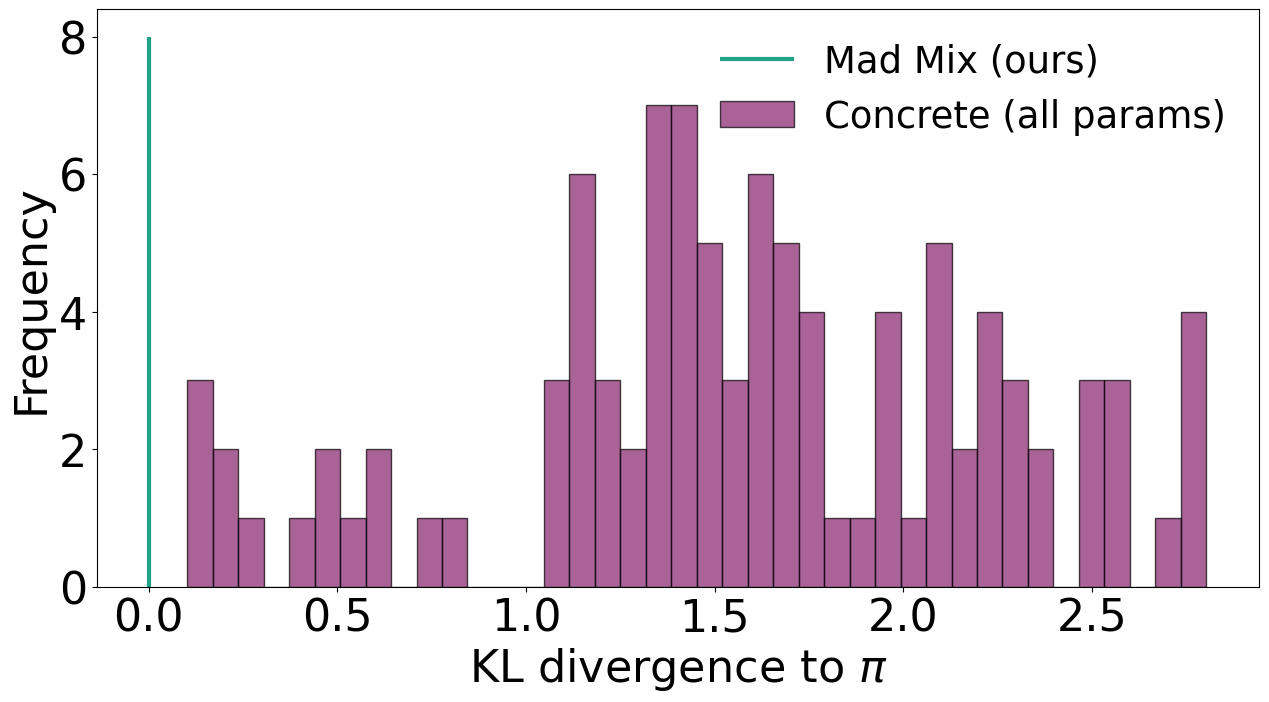

In [24]:
plt.vlines(-elbo_qN_twodim,ymin=0,ymax=8,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbos_twodim[-elbos_twodim<3],bins=40,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small',frameon=False)
plt.savefig(fig_path+'twodim_elbos.pdf', dpi=300, bbox_inches='tight')

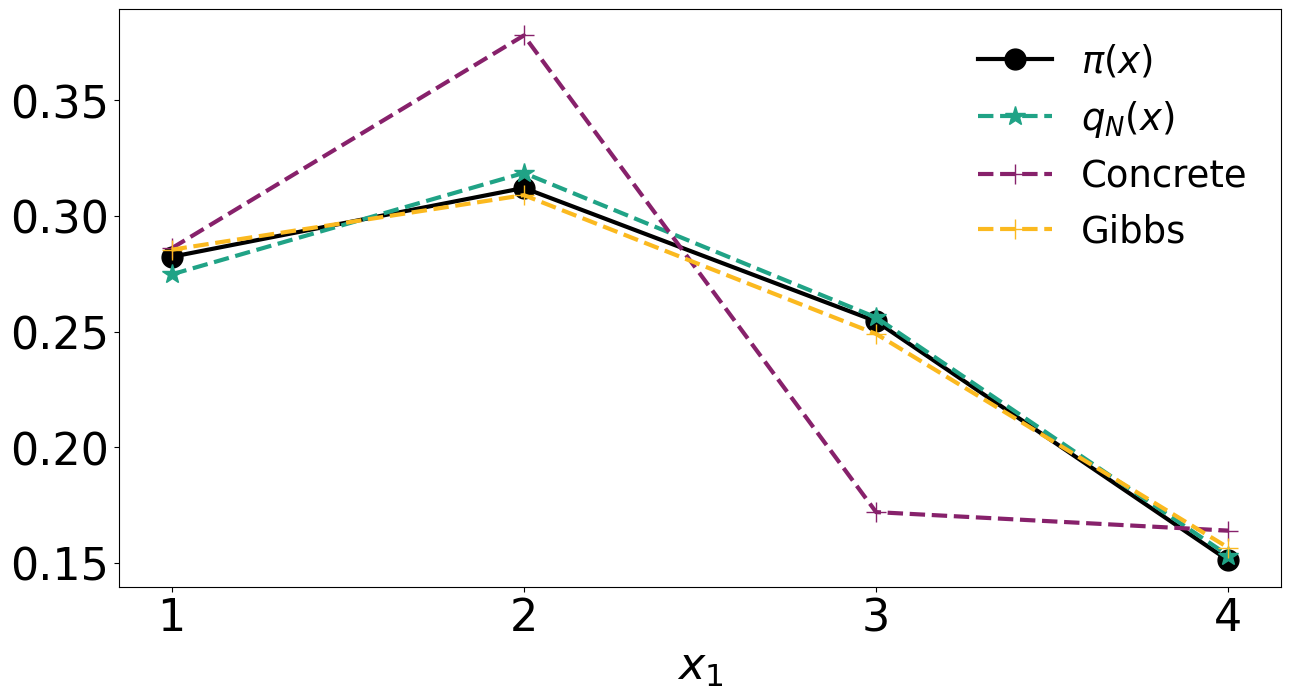

In [25]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(qvar_twodim,axis=1),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(densities_twodim[np.argmax(elbos_twodim),:,:],axis=1),c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,np.sum(gibbs_density_twodim,axis=1),c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.savefig(fig_path+'twodim_prbs1.pdf', dpi=300, bbox_inches='tight')

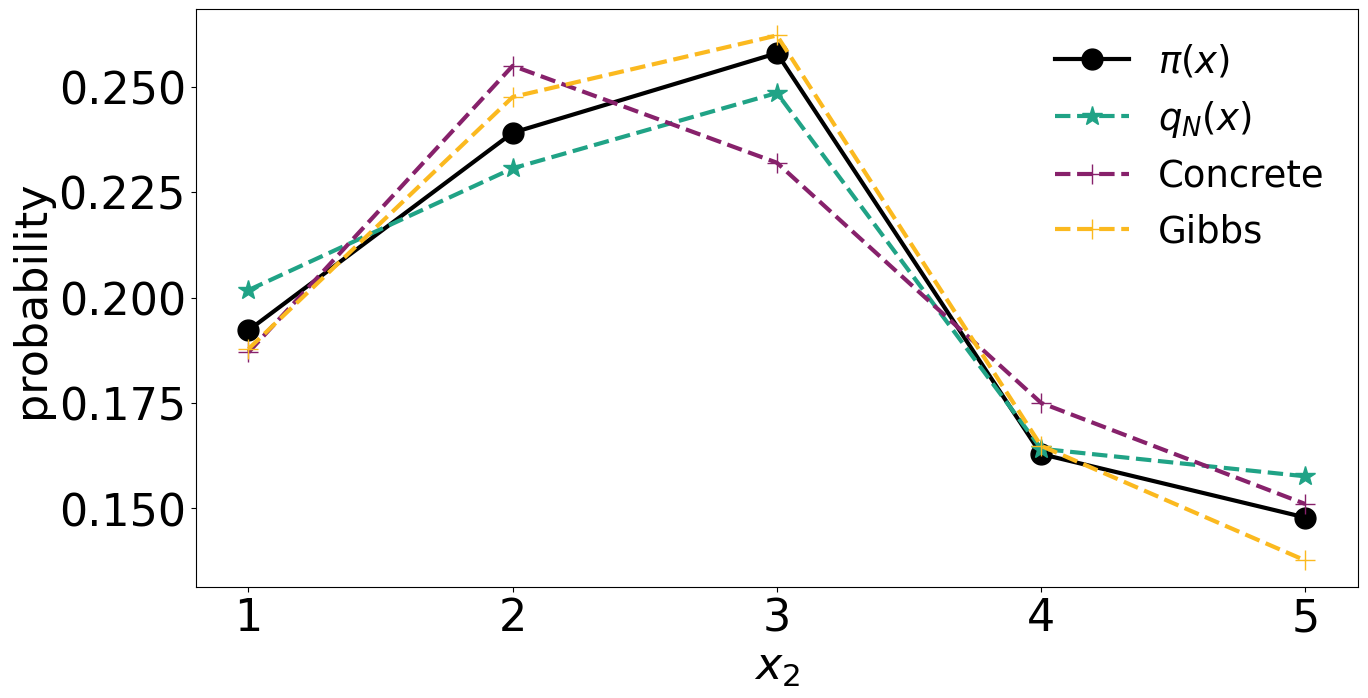

In [26]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,K2)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(qvar_twodim,axis=0),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(densities_twodim[np.argmax(elbos_twodim),:,:],axis=0),c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,np.sum(gibbs_density_twodim,axis=0),c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,K2)+0.5,labels=np.arange(1,1+K2))
plt.ylabel('probability')
plt.savefig(fig_path+'twodim_prbs2.pdf', dpi=300, bbox_inches='tight')

## Bimodal mixture example

We finally consider a 2D bimodal mixture example.
Specifically,
let $X_2|X_1=x$ be a discretized Gaussian on $\{1,\dots,20\}$ 
with mean $\mu_x$ and unit variance,
where $X_1\sim\mathsf{Unif}\{0,1\}$ and $\mu_0=4,\mu_1=15$.
Hence $\mathbb{P}(X_2=n\,|\,X_1=x)\propto\phi(n-\mu_x)$, $n\in[20], x=0,1$,
where $\phi$ is the pdf of a standard Gaussian.

A standard Gibbs sampler initialized at the first mode will get stuck:
moving only along $x_2$ is a highly unlikely proposal since
it corresponds to the probability of observing a tail value under the second mode.
An analogous argument applies to a sampler initialized at the second mode.

In the case of Mad Mix, we can leverage the fact that we can estimate the ELBO
to optimally weight two different flows, each initialized in a different mode.
That is, we consider a variational proposal of the form
$$
    q_N=wq_{N,0}+(1-w)q_{N,1},
$$
where $w\in(0,1)$ and $q_{N,i}=\frac{1}{N}\sum_{n=0}^{N-1} T^n q_i$
and $q_i$ is a distribution that covers mode $i$, $i=0,1$.
We then select
$$
    w=\arg\min_{\alpha\in(0,1)}
    \mathrm{D}_{\mathrm{KL}}
    (\alpha q_{N,0}+(1-\alpha)q_{N,1}\,||\,\pi),
$$
which can be estimated via gradient descent since
$$
    \frac{\mathrm{d}}{\mathrm{d}\alpha}
    \alpha q_{N,0}+(1-\alpha)q_{N,1}
    =\mathbb{E}_{q_{N,0}}
    \left[\log\frac{\alpha q_{N,0}+(1-\alpha)q_{N,1}}{\pi}\right]
    -\mathbb{E}_{q_{N,1}}
    \left[\log\frac{\alpha q_{N,0}+(1-\alpha)q_{N,1}}{\pi}\right].
$$

Below we run Gibbs sampler for 50,000 iterations (saving only the last 500)
and then show the density of each $q_{N,i}$.
Then we optimize $w$ and compare the density of $q_N$
with the results from the Gibbs sampler.

In [27]:
########################
########################
# target specification #
########################
########################
mu=np.array([4,15]) # the two modes
K1,K2=20,2
def aux_gausslp(aux): return -0.5*(np.arange(0,20)-mu[aux][:,np.newaxis])**2-0.5*np.log(2*np.pi)
def aux_gausslp_1d(y,x): return -0.5*(y-mu[x])**2-0.5*np.log(2*np.pi)

def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    y=x[0,:]
    aux=x[1,:]
    
    if axis==None: return -0.5*(y-mu[aux])**2-0.5*np.log(2*np.pi)
    if axis==0: return aux_gausslp(aux)
    if axis==1: 
        wlpy0=aux_gausslp_1d(y,0)+np.log(0.5)
        wlpy1=aux_gausslp_1d(y,1)+np.log(0.5)
        m=np.maximum(wlpy0,wlpy1)
        lpy=m+np.log(np.exp(wlpy0-m)+np.exp(wlpy1-m))
        out=np.ones((y.shape[0],2))
        out[:,0]=wlpy0
        out[:,1]=wlpy1
        return out-lpy[:,np.newaxis]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [28]:
# evaluate target density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)

mylp=np.exp(lp(x))
prbs=np.zeros((20,2))
prbs[:,0]=mylp[:20]
prbs[:,1]=mylp[20:]
prbs=prbs/np.sum(prbs)
prbs_mixture=np.copy(prbs)

In [29]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
def lq0_0(x,u):
    out=-0.5*(x[0,:]-mu[0])**2-0.5*np.log(2*np.pi)
    out[x[1,:]==0]=np.log(1e-32)
    return out
def lq0_1(x,u):
    out=-0.5*(x[0,:]-mu[1])**2-0.5*np.log(2*np.pi)
    out[x[1,:]==1]=np.log(1e-32)
    return out

N=100 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)
#myx=np.copy(x)
u=np.random.rand(2,40)

# mode 1
qvar0=np.exp(lqN(x,u,N,lq0_0,lp,xi))
myqvar0=np.zeros((20,2))
myqvar0[:,0]=qvar0[:20]
myqvar0[:,1]=qvar0[20:]

# mode 2
#u=np.random.rand(2,40)
qvar1=np.exp(lqN(x,u,N,lq0_1,lp,xi))
myqvar1=np.zeros((20,2))
myqvar1[:,0]=qvar1[:20]
myqvar1[:,1]=qvar1[20:]
qvar_mixture=np.copy(myqvar1)

In [30]:
###############################
###############################
# variational family settings #
###############################
###############################

N=100 # number of steps in qN
xi=np.pi/16
lq0 = lambda x : lqN(x,np.random.rand(2,40),N,lq0_0,lp,xi)
lq1 = lambda x : lqN(x,np.random.rand(2,40),N,lq0_1,lp,xi)
def lq(x,w):
    exp1=lq0(x)+np.log(w)
    exp2=lq1(x)+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))



# init x grid and fixed densities
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)
lq0_fixed=lq0(x)
lq1_fixed=lq1(x)
def lq_fixed(w):
    exp1=lq0_fixed+np.log(w)
    exp2=lq1_fixed+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))
full_lp=lp(x)

In [31]:
######################
######################
#    optimization    #
######################
######################

# optimization settings
np.random.seed(2023)
max_iter=10001
gamma=1e1
w=np.random.rand()
print('Initial w: '+str(w))
print()
print('Iter  |          w          |   gradient')

for t in range(max_iter):
    gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq_fixed(w)-full_lp))
    w=w-gradient*gamma/np.sqrt(t+1)
    w=min(1-1e-16,max(1e-16,w)) # constrain to (0,1)
    if t%(max_iter//10)==0: print('  '+str(t+1)+'   | '+str(w)+'  | '+str(gradient))
# end for

Initial w: 0.32198830399196776

Iter  |          w          |   gradient
  1   | 0.3964531248964157  | -0.007446482090444795
  1001   | 0.5000000000016797  | -6.436517985264345e-14
  2001   | 0.5000000000032626  | -1.6653345369377348e-16
  3001   | 0.5000000000032626  | -1.6653345369377348e-16
  4001   | 0.5000000000032626  | -1.6653345369377348e-16
  5001   | 0.5000000000032626  | -1.6653345369377348e-16
  6001   | 0.5000000000032626  | -1.6653345369377348e-16
  7001   | 0.5000000000032626  | -1.6653345369377348e-16
  8001   | 0.5000000000032626  | -1.6653345369377348e-16
  9001   | 0.5000000000032626  | -1.6653345369377348e-16
  10001   | 0.5000000000032626  | -1.6653345369377348e-16


In [32]:
weighted_q=np.exp(lq(x,w))
myqvar=np.zeros((20,2))
myqvar[:,0]=weighted_q[20:]
myqvar[:,1]=weighted_q[:20]
qvar_mixture=np.copy(myqvar)

In [33]:
elbo_qN_mixture=elbo_exact(np.log(qvar_mixture/np.sum(qvar_mixture)),np.log(prbs_mixture))

In [34]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
gibbs_ss=5000
x0=np.array([15,1])
gibbs_samples_mixture=gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.8,verbose=True)

In [35]:
# get density and compute ELBO
gibbs_density_mixture=plt.hist2d(gibbs_samples_mixture[0,:],gibbs_samples_mixture[1,:],density=True,
                         bins=[np.arange(0,21),np.arange(0,3)])[0]
plt.clf()
gibbs_density_mixture[gibbs_density_mixture<1e-32]=1e-32
elbo_gibbs_mixture=elbo_exact(np.log(gibbs_density_mixture),np.log(prbs_mixture))

<Figure size 1500x750 with 0 Axes>

In [36]:
########################
########################
#       Concrete       #
########################
########################
flows_mixture     = pkl_load('mixture/mixture_flows')
losses_mixture    = pkl_load('mixture/mixture_losses')
cpu_times_mixture = pkl_load('mixture/mixture_cpu_times')
sim_size_mixture     = len(flows_mixture)
max_iters_mixture    = losses_mixture.shape[-1]
print('Total training time: '+str(cpu_times_mixture.sum()/3600)+' hours')

Total training time: 137.13728308959935 hours


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

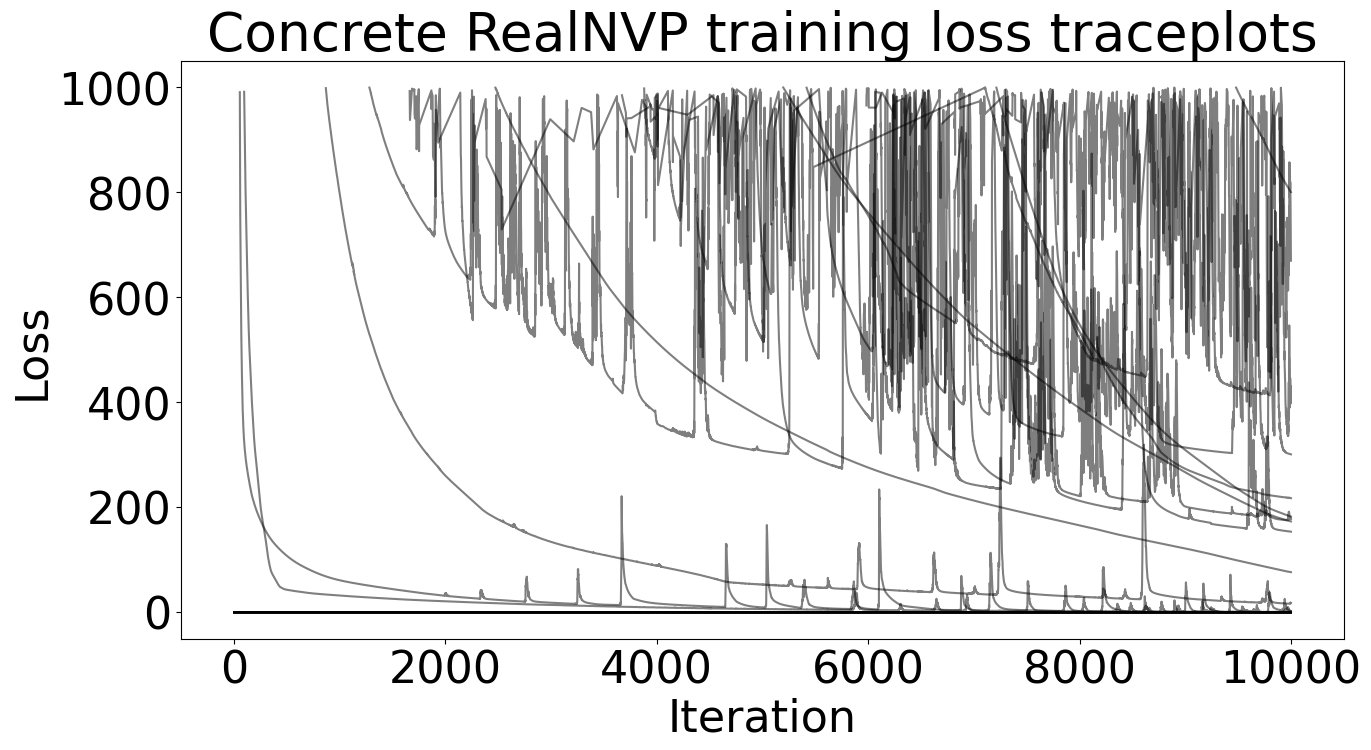

In [37]:
# loss traceplot
threshold=1000
for i in range(sim_size_mixture): plt.plot(np.arange(max_iters_mixture)[losses_mixture[i,:]<threshold],losses_mixture[i,losses_mixture[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [38]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(0)
sample_size=1000
samples_mixture=np.zeros((sim_size_mixture,2,sample_size))
densities_mixture=np.zeros((sim_size_mixture,K1,K2))
elbos_mixture=-np.inf*np.ones(sim_size_mixture)

for i in range(sim_size_mixture):
    print(str(i+1)+'/'+str(sim_size_mixture),end='\r')
    tmp_flow=flows_mixture[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflatten(tmp_sample,K2) # 1d->2d
    samples_mixture[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist2d(tmp_sample[0,:],tmp_sample[1,:],density=True,
                         bins=[np.arange(0,21),np.arange(0,3)])[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    densities_mixture[i,:,:]=tmp_density
    
    # estimate elbo
    elbos_mixture[i]=elbo_exact(np.log(tmp_density),np.log(prbs_mixture))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_26745/3019726877.py:19: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_26745/3019726877.py:20: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<Figure size 1500x750 with 0 Axes>

In [39]:
i_starmix=np.argmax(elbos_mixture) #
print('Optimal flow: '+str(i_starmix))

Optimal flow: 110


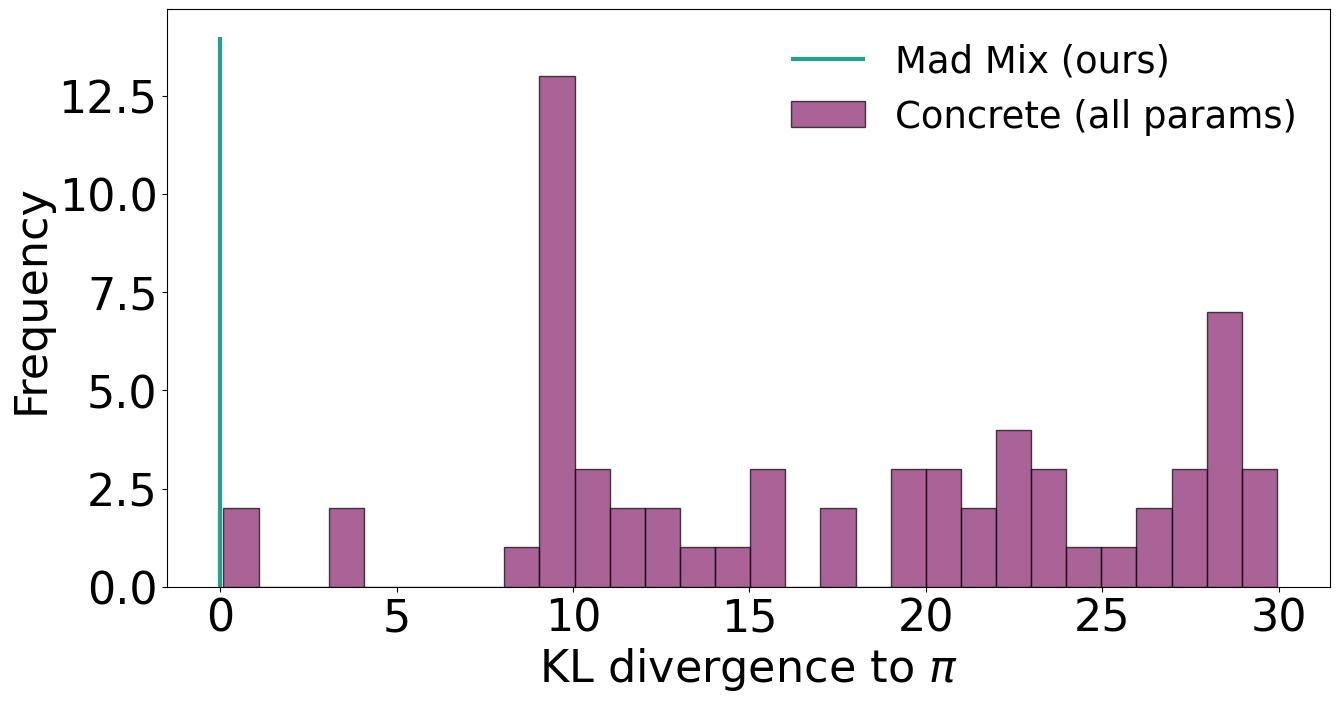

In [40]:
plt.vlines(-elbo_qN_mixture,ymin=0,ymax=14,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbos_mixture[-elbos_mixture<30],bins=30,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small',frameon=False)
plt.savefig(fig_path+'mixture_elbos.pdf', dpi=300, bbox_inches='tight')

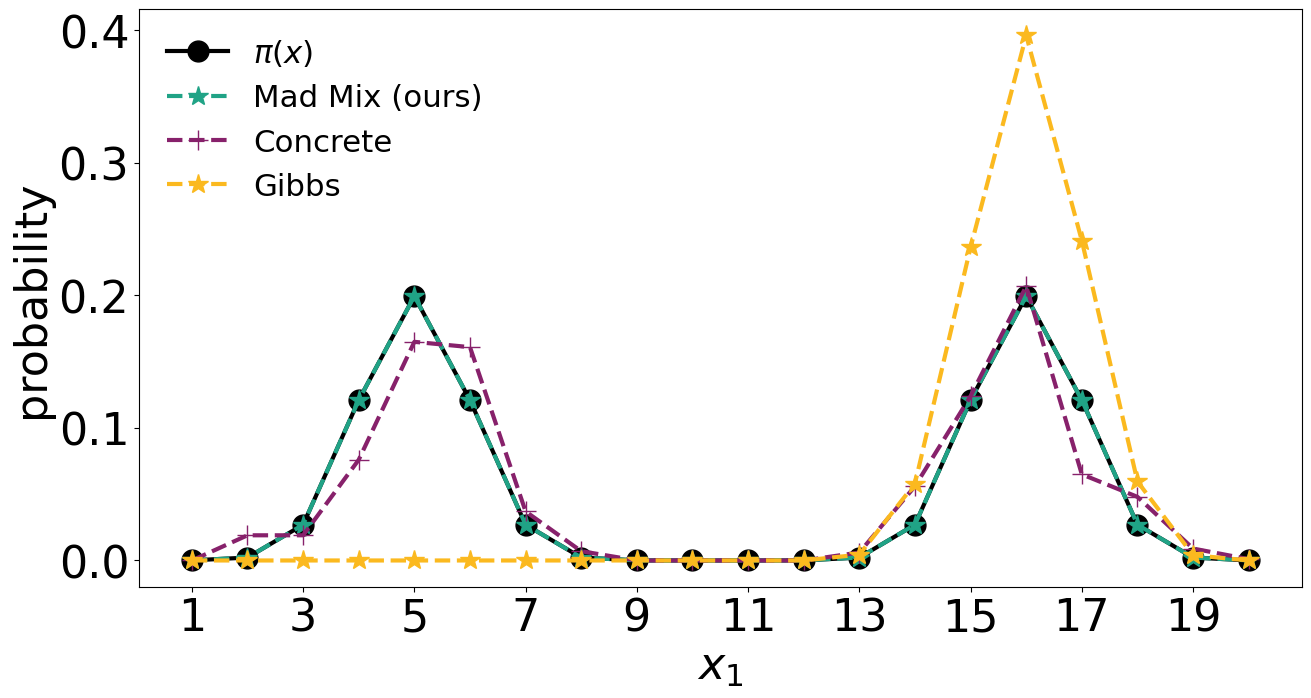

In [41]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs_mixture/np.sum(prbs_mixture),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(qvar_mixture/np.sum(qvar_mixture),axis=1),c='#20A386FF', 
         label='Mad Mix (ours)',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(densities_mixture[np.argmax(elbos_mixture),:,:],axis=1),
         c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,np.sum(gibbs_density_mixture/np.sum(gibbs_density_mixture),axis=1),c='#FBB91FFF', 
         label=r'Gibbs',lw=3,ls='dashed',ms=15,marker='*')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,20,step=2)+0.5,labels=np.arange(1,21,step=2))
plt.ylabel('probability')
plt.savefig(fig_path+'mixture_prbs.pdf', dpi=300, bbox_inches='tight')

In [42]:
print('ELBO(qN||π)='+str(elbo_qN_mixture))
print('ELBO(qGibbs||π)='+str(elbo_gibbs_mixture))
print('ELBO(qConcrete_opt||π)='+str(elbos_mixture[np.argmax(elbos_mixture)]))

ELBO(qN||π)=-1.5349621298738328e-11
ELBO(qGibbs||π)=-0.6939400015849806
ELBO(qConcrete_opt||π)=-0.09335160026513098
